In [1]:
from IPython.display import Image, display

# Quick hisotry reminder, and challenge description.

On April 15, 1912 the Titanic was called "unsinkable". However as we know, this beautiful ship have sank after colliding with an iceberg. Unofurunately there weren't enough lifeboats for everyone,
in as result, 1502 out of 2224 people died in a blistering cold. Our main challenge will be simple. Use machine learning to create a model, that predicts which passengers survived the Titanic disaster.

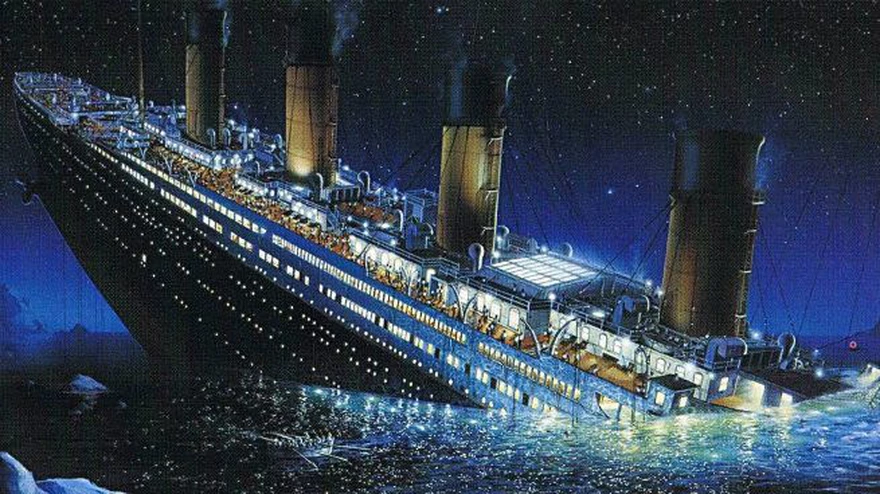

In [2]:
display(Image(filename='titanicII.jpeg'))

# Required imports to perform the analytics

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score,accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier

# Importing the data

In [4]:
titanic_df = pd.read_csv('titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data cleaning and preparation.

The first step in our analysis, is to check if we have good data types in our variables.

In [5]:
titanic_df.info()
print(f"Our dataset contains {titanic_df.shape[0]} entries and {titanic_df.shape[1]-1} features.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Our dataset contains 891 entries and 11 features.


We can see that, almost everything is good. However we can see two things. First - we have a lot of null values that we must take care of, and secondly - variable Age is shown as float.
We must take care of it, and change it to an int.


In [6]:
print(f"In Age variable, {round(titanic_df.Age.isnull().sum() / titanic_df.shape[0] * 100,3)}% entries are empty.")

In Age variable, 19.865% entries are empty.


Lets explore the descriptive statistics of Age.


In [7]:
titanic_df['Age'].describe().T

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We can see that the min value of Age is 0.42. That's the reason why our variable was saved as float. We will change that values to 0 to get rid of that problem. Also we will replace all NaN values with rounded nanmedian value to the nearest integer . According to the documentation, nanmedian will return a median along the specific axis, while ignoring all NaNs - which is what we want.


In [8]:
#First let's change the min value to 0
min_age = titanic_df['Age'].min()
titanic_df['Age'].replace(min_age,0,inplace=True)
titanic_df.iloc[803]

PassengerId                                804
Survived                                     1
Pclass                                       3
Name           Thomas, Master. Assad Alexander
Sex                                       male
Age                                        0.0
SibSp                                        0
Parch                                        1
Ticket                                    2625
Fare                                    8.5167
Cabin                                      NaN
Embarked                                     C
Name: 803, dtype: object

In [9]:
#Secondly, lets calculate the nanmedian value
nanmedian = np.nanmedian(titanic_df['Age'])
print(f"The nanmedian value is equal to: {nanmedian}")

#Thirdly, lets replace the nan values with the value that we caluclated earlier.

titanic_df['Age'].fillna(nanmedian,inplace=True)

print(f"NaN values left in Age variable is equal to {titanic_df['Age'].isnull().sum()}")

#And at least but not last, lets change the data type.

titanic_df['Age'] = titanic_df['Age'].astype(int)

print(f'The current data type of Age column is {titanic_df["Age"].dtype}')

The nanmedian value is equal to: 28.0
NaN values left in Age variable is equal to 0
The current data type of Age column is int64


Lets investigate more of the NaN values in our data frame.



In [10]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that, out of 891 rows, 686 entries in Cabin variable are empty. We cannot do anything about it, so we will drop that variable.

In [11]:
titanic_df.drop('Cabin', axis=1,inplace=True)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S


We are left with 2 empty walues in Embarked column. Lets check it out.

In [12]:
print(f"The unique values of Embarked are : {titanic_df['Embarked'].unique()}")
titanic_df[titanic_df['Embarked'].isnull()]



The unique values of Embarked are : ['S' 'C' 'Q' nan]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,NaN


In [13]:
#Lets check out form what Port of Embarktion most people have the first-class ticket.

titanic_df[titanic_df['Pclass']==1].groupby('Embarked')['Embarked'].count()

#When people we're having first-class ticket, most likely they were form Southampton. So we will fill NaN values in Embarked column with "S".

titanic_df['Embarked'].fillna('S',inplace=True)

print(f"NaN values left in Embarked variable is equal to {titanic_df['Embarked'].isnull().sum()}")

NaN values left in Embarked variable is equal to 0


Lets check now if everything is clear with our features.

In [14]:
print(f"NaN values left in our data set is equal to {titanic_df.isnull().sum().sum()}\n")
titanic_df.info()

NaN values left in our data set is equal to 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    int64  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(1), int64(6), object(4)
memory usage: 76.7+ KB


Now lets check if values inside our columns makes any sense.

In [15]:
for column in titanic_df.drop(['PassengerId','Name','Fare','Age','Ticket'],axis=1).columns:
    print(f"The unique values of column {column} are: {titanic_df[column].unique()}")

The unique values of column Survived are: [0 1]
The unique values of column Pclass are: [3 1 2]
The unique values of column Sex are: ['male' 'female']
The unique values of column SibSp are: [1 0 3 4 2 5 8]
The unique values of column Parch are: [0 1 2 5 3 4 6]
The unique values of column Embarked are: ['S' 'C' 'Q']


# Exploratory Data Analysis

EDA will give as a lot of information about our passengers. It's one of the most important thing in creating a model, cause we can find a lot of relationships between our variables. And sometimes we can even determine difference between classes without even creating a Machine Learning model.

In [16]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S


Text(0.5, 1.0, 'Not Survived vs  Survived')

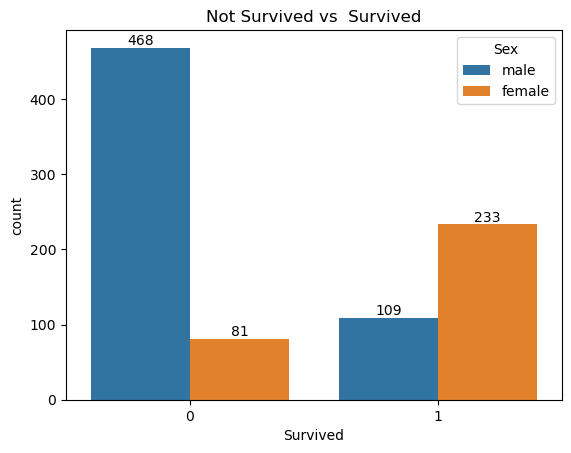

In [17]:
#Lets check how many of our passengers survived based on Sex.

ax = sns.countplot(data=titanic_df, x='Survived', hue='Sex')
ax.bar_label(container = ax.containers[0]);
ax.bar_label(container = ax.containers[1]);
plt.title('Not Survived vs  Survived')


We can see that, almost 6 times more man died than woman. Maybe it's related to the famous words from film "Titanic":  "Woman and children first". Lets add a new information about Sex. If age is less or equal to 16 then we will consider that passenger as child.

In [18]:
def child(age,sex):
    if age <= 16:
        return "child"
    else:
        return sex
titanic_df['Sex'] = titanic_df[['Age','Sex']].apply(lambda row: child(row['Age'], row['Sex']), axis=1)

Text(0.5, 1.0, 'Not Survived vs  Survived')

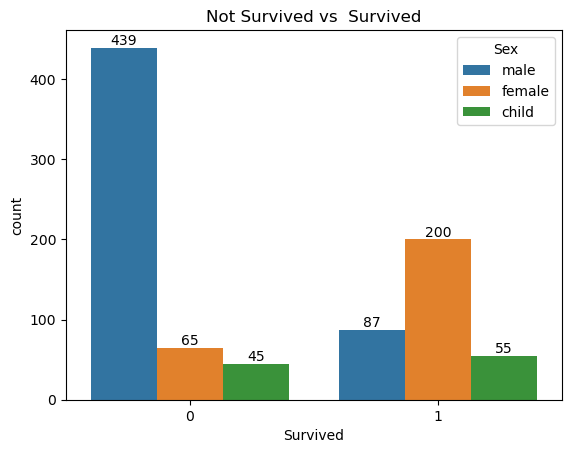

In [19]:
#Lets check how many of our passengers survived based on Sex again.
ax = sns.countplot(data=titanic_df, x='Survived', hue='Sex')
ax.bar_label(container = ax.containers[0]);
ax.bar_label(container = ax.containers[1]);
ax.bar_label(container = ax.containers[2])
plt.title('Not Survived vs  Survived')

We can see that not so much more of children survived than have died. The biggest difference between who survived and who died based on Sex, is in man group.

Lets compare the chances to survive based on a class ticket.

Text(0, 0.5, 'Chances of Survival')

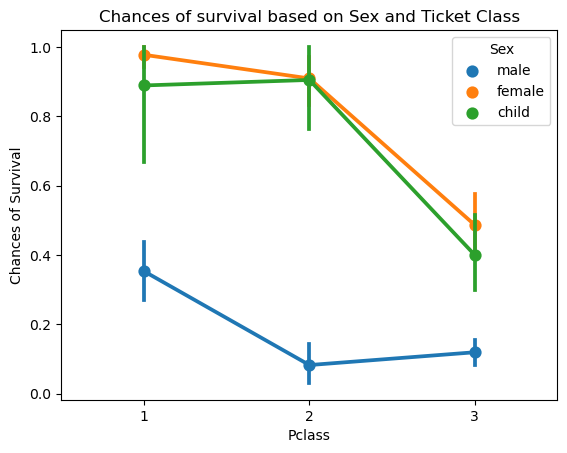

In [20]:
sns.pointplot(data=titanic_df, x='Pclass',y='Survived',hue='Sex');
plt.title('Chances of survival based on Sex and Ticket Class')
plt.ylabel('Chances of Survival')

The error bar is shown as Confidence Interval(95%). It's calculated around the mean, allowing us for an estimation of the range within which the population mean can be expected. Seaborn uses the bootstrap method to calculate that CI. Again we can say, that male, were having smallest chances of survival. However, only on that particular sex, 3'rd class ticket were giving man, higher chances of survival. Basing on that chart we can say that, woman have the highest chances of survival. However we can see, that if a woman or a child, were having 3'rd class ticket, their chances of surivival dropped drasitcally. In conclusion we can say, that Sex definitelly deteminates chances of survival.

Lets check out the prices that our passengers have paid for a ticket.


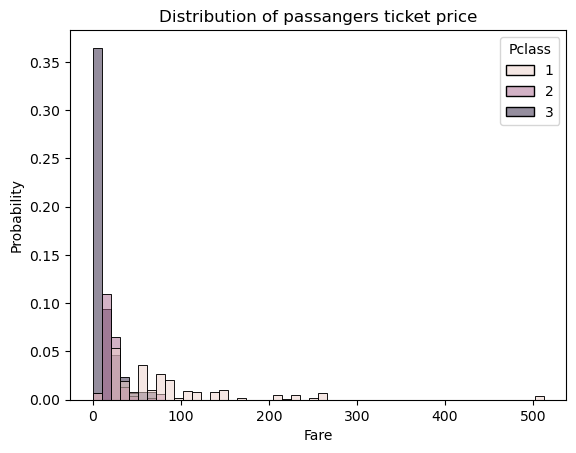

In [21]:
sns.histplot(data=titanic_df, x='Fare', hue='Pclass',bins=50,stat='probability',palette=None);
plt.title("Distribution of passangers ticket price");

We can say that, most of our passengers paid less than 100$, and most of them were having third class tickets. However, if a person have paid more than 90$ then it was a first class ticket. And as we know from previous charts, if a passenger wasn't a man, third class tickets were decreasing your chances of survival. We can also see, that we probably have some outliers. Cause we can see a big price gap between 250$ and 510$. We can use Z-score method to determine what observation is an outlier. We can calculate Z-Score by calculating: Z = $\frac{X-μ}{S}$ , where $X$ is a particular observation in our dataset, $μ$ is considered as mean of our variable and $S$ is a standard deviation. If Z-Score is greater than 3 or less than -3 the particular observation is considered as Outlier. Lets explore our data connected to Fare a littlebit more.

In [22]:
mean = titanic_df['Fare'].mean()
deviation = titanic_df['Fare'].std()
titanic_df['Z_Score'] = ["Outlier" if (x-mean)/deviation > 3 or (x-mean)/deviation < -3 else "Standard Observation" for x in titanic_df['Fare']]
titanic_df[titanic_df['Z_Score']=='Outlier']



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Z_Score
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263.0000,S,Outlier
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23,3,2,19950,263.0000,S,Outlier
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24,0,1,PC 17558,247.5208,C,Outlier
258,259,1,1,"Ward, Miss. Anna",female,35,0,0,PC 17755,512.3292,C,Outlier
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50,0,1,PC 17558,247.5208,C,Outlier
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18,2,2,PC 17608,262.3750,C,Outlier
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24,3,2,19950,263.0000,S,Outlier
377,378,0,1,"Widener, Mr. Harry Elkins",male,27,0,2,113503,211.5000,C,Outlier
380,381,1,1,"Bidois, Miss. Rosalie",female,42,0,0,PC 17757,227.5250,C,Outlier
438,439,0,1,"Fortune, Mr. Mark",male,64,1,4,19950,263.0000,S,Outlier


We can see that 20 of our records are considered as outliers and all of them were from first class tickets. In the future they may be causing us some problems, but for now we will leave them as they are.

The next stop of our analysis is to check if, age is connected to the survivalability. 

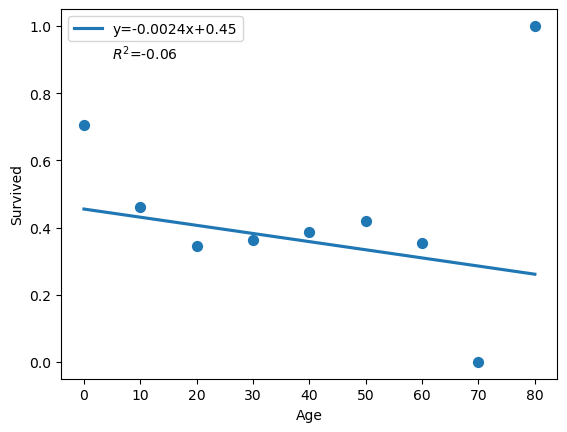

In [23]:
age_bins = list(range(0,95,10))
slope, intercept, r_value, p_value, std_err = stats.linregress(x=titanic_df['Age'], y=titanic_df['Survived'])

# use line_kws to set line label for legend
ax = sns.regplot(x="Age", y="Survived", data=titanic_df, ci=None,x_bins=age_bins,
 line_kws={'label':"y={0:.4f}x+{1:.2f}".format(slope,intercept)})
plt.text(5,0.9,f"$R^2$={round(r_value,2)}")
ax.legend()
plt.show()

We can see that, there's a correlation between age and surivalability. The chances of survival decreases, when person is older. Lets see how it looks with sex variable.

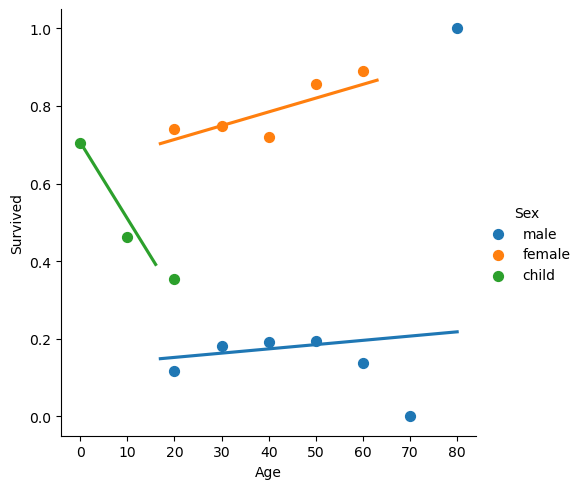

In [24]:
sns.lmplot(data=titanic_df, x='Age', y='Survived', x_bins=age_bins, hue='Sex', ci=None);

Again, male around age 17-20 were having the lowest chance of surviving the titanic disaster. However in male and female group, the older you get, the higer were chances of survival. We can also see a nice thing, the oldest passenger was 80 years old male, and he survived the crash!

The next thing we can check, how many of our passengers were traveling alone or with someone.

In [25]:
def alone(sib,parch):
    if sib + parch == 0:
        return "Alone"
    else:
        return "With Someone"
    
titanic_df['Alone'] = titanic_df[['SibSp','Parch']].apply(lambda row: alone(row['SibSp'], row['Parch']), axis=1)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Z_Score,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Standard Observation,With Someone
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Standard Observation,With Someone
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Standard Observation,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Standard Observation,With Someone
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Standard Observation,Alone


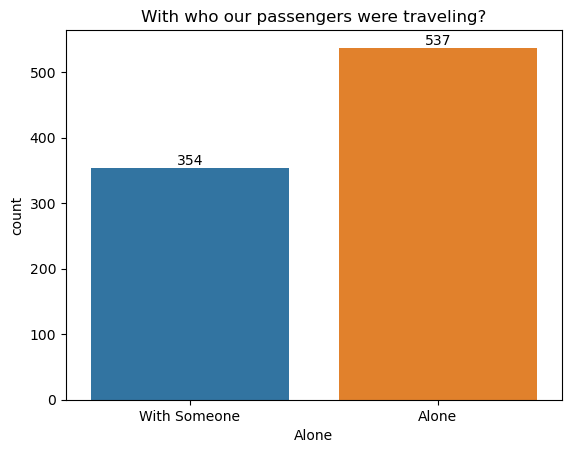

In [26]:
ax = sns.countplot(data=titanic_df, x='Alone')
ax.bar_label(container=ax.containers[0])
plt.title("With who our passengers were traveling?");

Most of our passengers were traveling alone. Lets check if traveling with someone enhances your chances of surival.

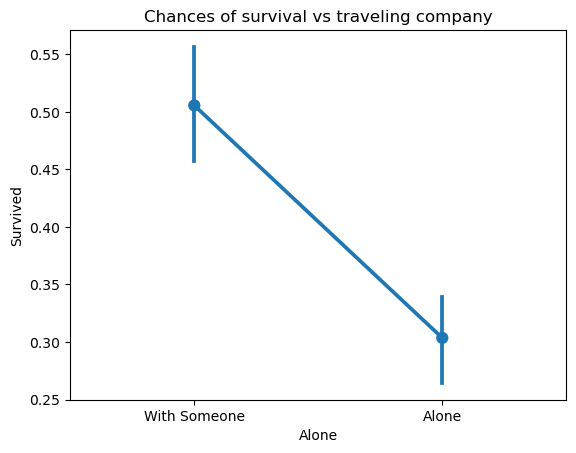

In [27]:
sns.pointplot(data=titanic_df, x='Alone', y='Survived');
plt.title('Chances of survival vs traveling company');

We can say that, traveling with someone grately improves your chances to survive.

The last thing to do during EDA process, it's to check the correlation between our variables.

/var/folders/y1/zhv55l5j43q6_j75lrhgg4540000gn/T/ipykernel_1606/1392876804.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_df.drop('PassengerId',axis=1).corr(),annot=True);


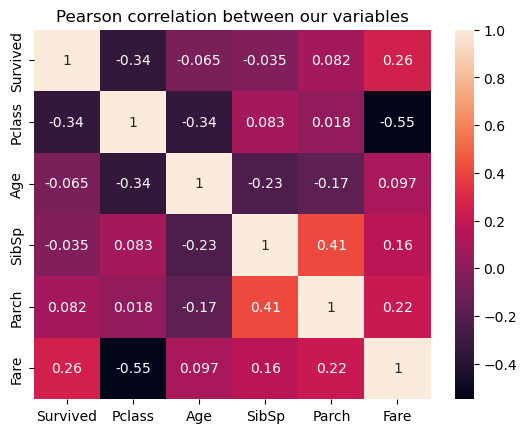

In [28]:
sns.heatmap(titanic_df.drop('PassengerId',axis=1).corr(),annot=True);
plt.title('Pearson correlation between our variables');

The biggest value of correlation is between Fare and Pclass. It means that, the more you pay for your ticket, the higher(1 is the biggest one so that's why correlation is in "-") class of it you will get, and that's logical. We can also see, a nice correlatioo between Pclass and Survived variables. It tells us, that if you're traveling with 1'st class ticket, the higher your chances of survival.

# Machine Learning 
1. Dummy model - to evaluate how well our model is doing, we will comapre it to a Dummy model. Dummy model is a tool, that can tell us, if our true model will be better than random guessing. Dummy model does not use any of the features, that's just basic probability measurements. We will be using the stratified method. It means that, our predictors method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. But first we will create some dummy variables, and delete the features that we don't need in building our models.

In [29]:
titanic_df = titanic_df.drop(['PassengerId','Name','Z_Score','SibSp','Parch','Ticket'],axis=1)
titanic_df.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Alone
0,0,3,male,22,7.2500,S,With Someone
1,1,1,female,38,71.2833,C,With Someone
2,1,3,female,26,7.9250,S,Alone
3,1,1,female,35,53.1000,S,With Someone
4,0,3,male,35,8.0500,S,Alone


              precision    recall  f1-score   support

           0       0.66      0.68      0.67       167
           1       0.44      0.42      0.43       101

    accuracy                           0.58       268
   macro avg       0.55      0.55      0.55       268
weighted avg       0.57      0.58      0.58       268

The overall precision score of our model was 0.44


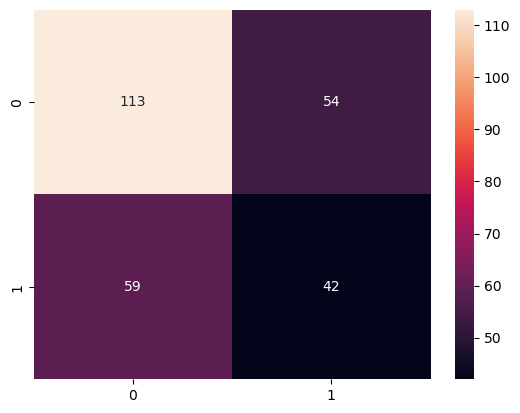

In [30]:
#Building the model
X = titanic_df.drop('Survived',axis=1)
y = titanic_df.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)

dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_train,y_train)
dummy_predictions = dummy_model.predict(X_test)
print(classification_report(y_test,dummy_predictions))
sns.heatmap(confusion_matrix(y_test,dummy_predictions),annot=True, fmt='g')
print(f"The overall precision score of our model was {round(precision_score(y_test, dummy_predictions),2)}")




The accuracy is calculated by this particular equation: $Recall = \frac{TP + TN}{TP+TN+FP+FN}$. It means that 38% of the times, our model was guessing corectly the Survived class based just on random gusessing.

2. Logistic Regression - on this part we will be creating the models based on a Logistic Regression algorithm. However first, we need to create a dummy variables, to encode as numbers our non-numeric variables.

The mean accuracy score on train set is equal to: 0.81
The mean accuracy on test set is equal to 0.78
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       178
           1       0.64      0.79      0.71        90

    accuracy                           0.78       268
   macro avg       0.76      0.78      0.77       268
weighted avg       0.80      0.78      0.78       268



<Axes: ylabel='Feature'>

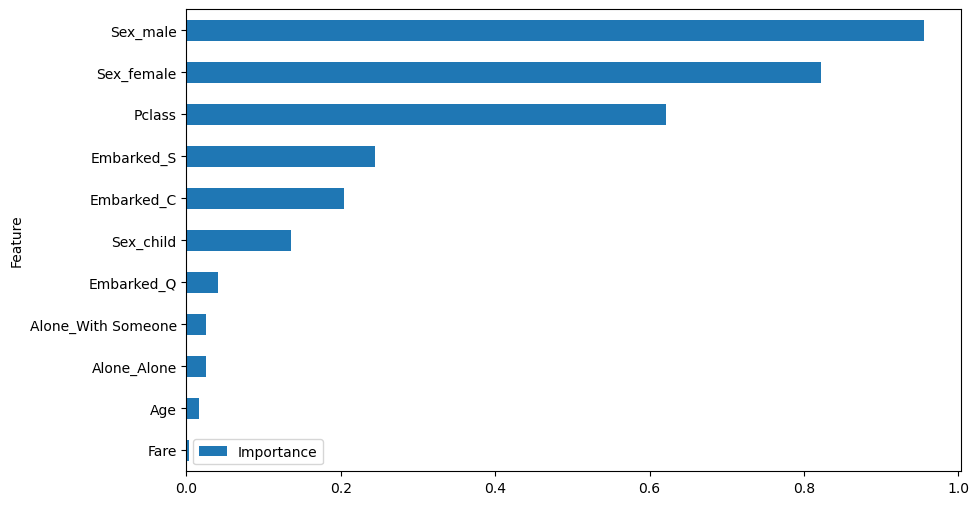

In [31]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

log_model = LogisticRegressionCV(max_iter=1000);
log_model.fit(X_train, y_train);
log_model_predictions = log_model.predict(X_test)
print(f"The mean accuracy score on train set is equal to: {round(log_model.score(X_train,y_train),2)}")
print(f"The mean accuracy on test set is equal to {round(log_model.score(X_test,y_test),2)}")
print(classification_report(log_model_predictions,y_test))


coefficients = log_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))







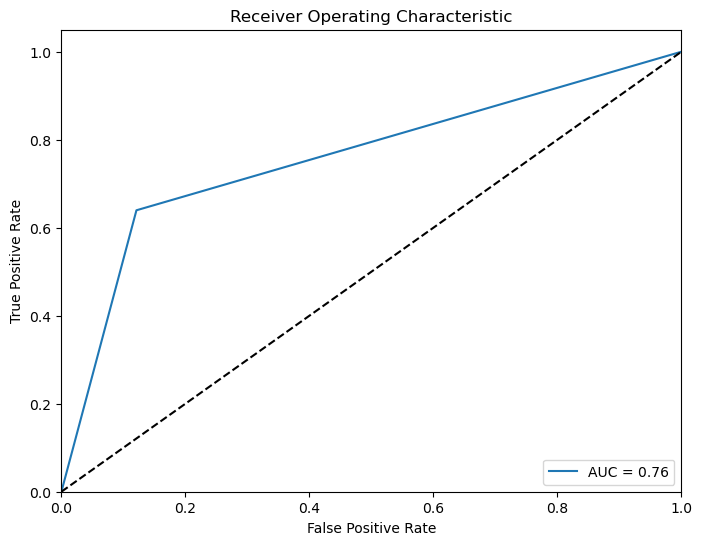

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, log_model_predictions)
roc_auc = roc_auc_score(y_test, log_model_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

We can see that, based just on a simple logistic regression we are getting far more better results than just random guessing. Basing on accuracy on test data and training data, we can see that there's no sign of overfitting or underfitting. We can also see, that relationship between False Positive Rate and True Positive Rate is not so bad, since the Area Under the Curve is equal to 0.76. In general, our model is quite good and searching the relationships between data, and generalizing the unseen data. However we can see that the variable "Fare" has almost no importance in terms of building the model. We can also try to perform a GridSearch to search the best parameters for our model. We will try to upgrade the model, by searching the best way to penaltizing(L1 and L2 penalty) a big weights in our model. We will also try to set the best regularization for our features.

In [33]:
#GridSearch
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
params = {'Cs':[0.001,0.01,0.1,1,10,100],'penalty':['l1','l2']}
model = LogisticRegressionCV(max_iter=10000,solver='liblinear',)
grid_search = GridSearchCV(model,params,cv=5, scoring='recall')
grid_search.fit(X_train,y_train)
print(f"The best parameters for our models are {grid_search.best_params_}")
print(f"The best score for our model is equal to {grid_search.best_score_}")




/Users/grzegorznaporowski/anaconda3/envs/moje_srodowisko/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/grzegorznaporowski/anaconda3/envs/moje_srodowisko/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/grzegorznaporowski/anaconda3/envs/moje_srodowisko/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1760, in fit
    self._validate_params()
  File "/Users/grzegorznaporowski/anaconda3/envs

The best parameters for our models are {'Cs': 100, 'penalty': 'l2'}
The best score for our model is equal to 0.6930272108843538


The mean accuracy score on train set is equal to: 0.8
The mean accuracy on test set is equal to 0.81
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       177
           1       0.70      0.78      0.74        91

    accuracy                           0.81       268
   macro avg       0.79      0.81      0.80       268
weighted avg       0.82      0.81      0.82       268



<Axes: ylabel='Feature'>

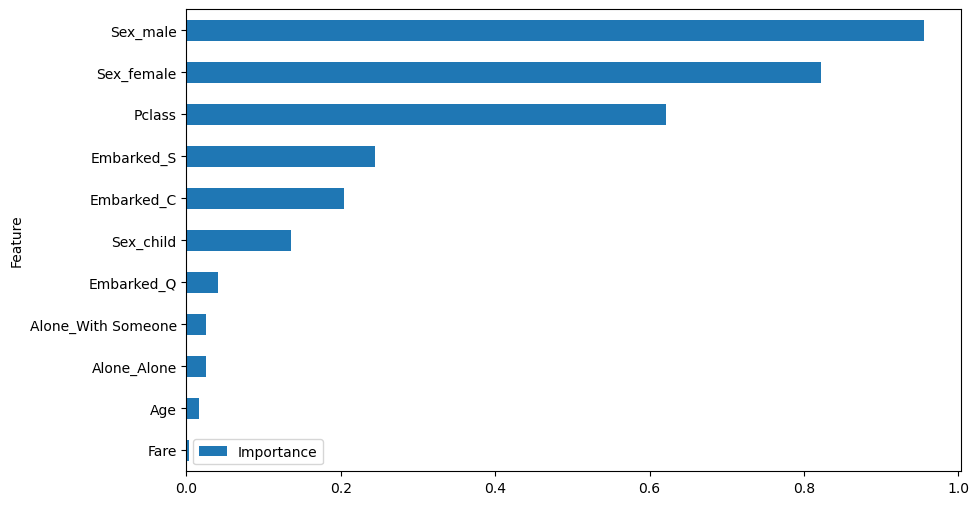

In [34]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
model = LogisticRegressionCV(max_iter=10000,solver='liblinear',Cs=100, penalty='l2')
model.fit(X_train,y_train)
log_model_predictions = log_model.predict(X_test)
print(f"The mean accuracy score on train set is equal to: {round(log_model.score(X_train,y_train),2)}")
print(f"The mean accuracy on test set is equal to {round(log_model.score(X_test,y_test),2)}")
print(classification_report(log_model_predictions,y_test))


coefficients = log_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


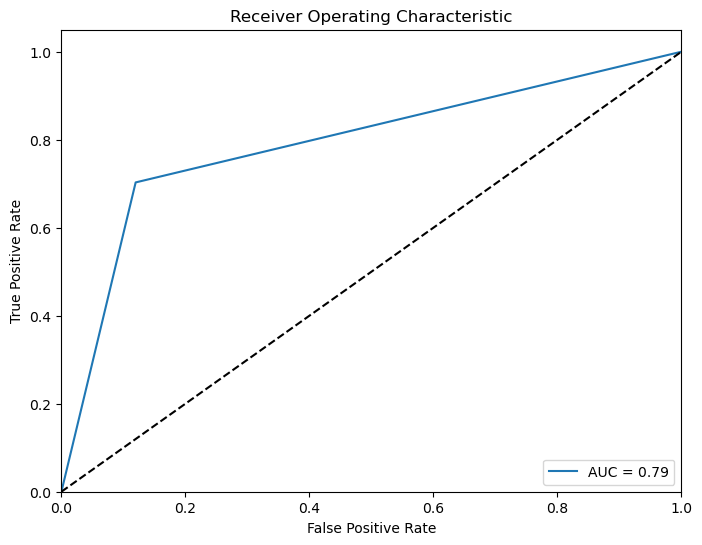

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, log_model_predictions)
roc_auc = roc_auc_score(y_test, log_model_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix after turning up the hyperparameters')

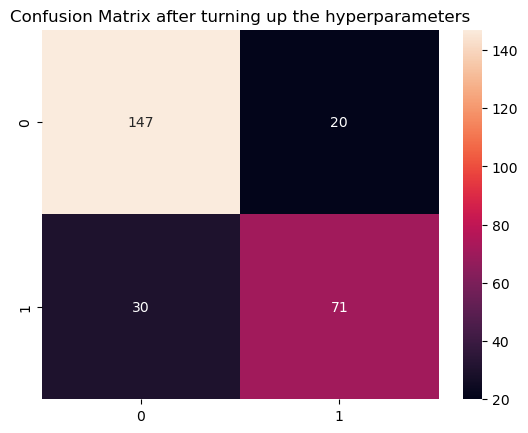

In [36]:
sns.heatmap(confusion_matrix(y_test,log_model_predictions),fmt='g', annot=True)
plt.title("Confusion Matrix after turning up the hyperparameters")

After the parameter Tuning, the accuracy score slightly got better. We can also see, that precision score in both groups have gone slightly better, but we have lost some points in recall score in group 1. The AUC have also got slightly better but not so much. In general we can say that model after turning the hyperparameters is better than the simple logistic regression, however it seems, that logistic regression is not catching all of the relationships between all of our data. We will now check, if Random Forest model can handle that problem.

3. Random Forest model. As we seen earlier, logistic regression may not be the best choice to predict the survivors of the titanic crash. We can check if decision tree model can handle that problem, however, a single decision tree have a major problem - tendency to overfitting. So we will try to use much more of single decision trees, to overcome that problem.

In [37]:
random_forest = RandomForestClassifier()
X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
random_forest.fit(X_train,y_train)
random_forest_predictions = random_forest.predict(X_test)
print(f"Random Forest train score is equal to {round(random_forest.score(X_train,y_train),3)}")
print(f"Random Forest test score is equal to {round(random_forest.score(X_test,y_test),3)}")

Random Forest train score is equal to 0.979
Random Forest test score is equal to 0.836


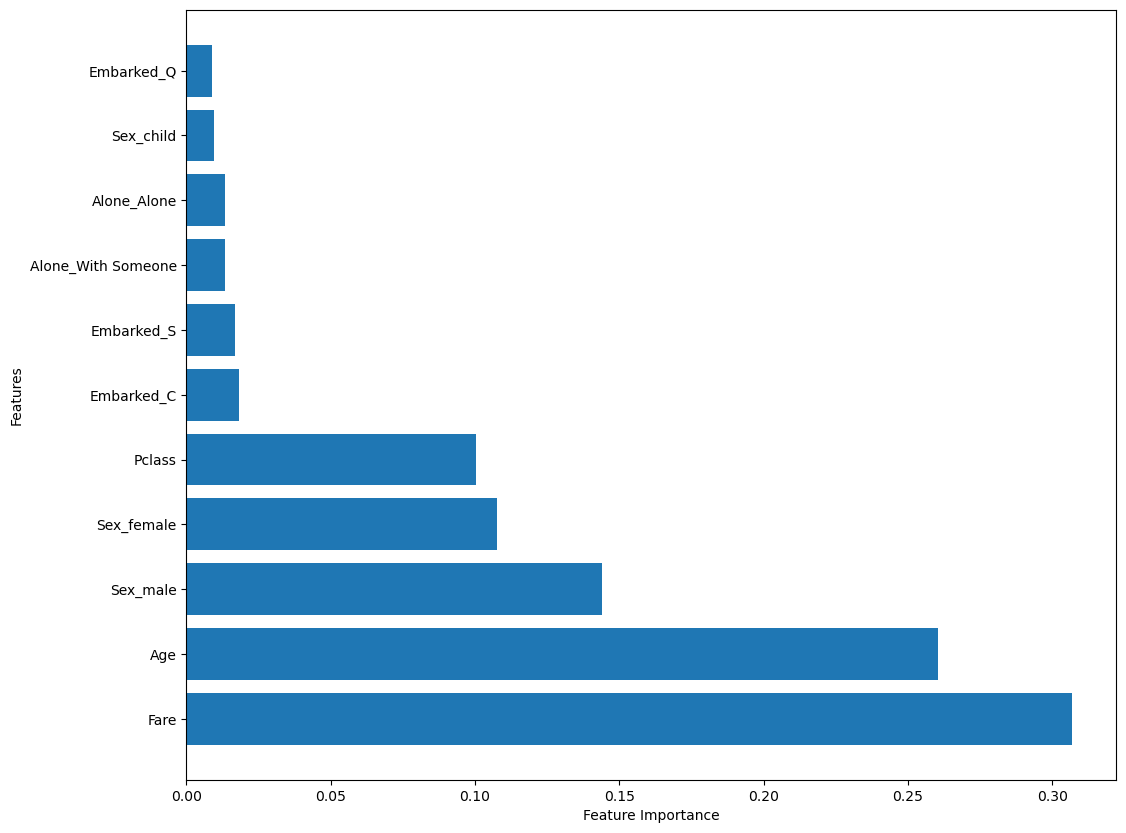

In [38]:
plt.figure(figsize=(12, 10))
sorted_indices = np.argsort(random_forest.feature_importances_)
sorted_values = random_forest.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

We can see something odd. The importances of featuer is totally different in comparision to logistic regression. In previous model Fare importance was almost 0, and in Random Forest is the most important feature. We can also see that score on Train set is far better than on test set. It could be sign of overfitting on our model. Lets perform a Cross Validation test to check that.

In [39]:
random_forest = RandomForestClassifier()
cv_score = cross_val_score(random_forest,X,y,cv=10)
print('Cross-validation scores on train set (10-fold):', cv_score)
print('Mean cross-validation score on train set (10-fold): {:.3f}'
     .format(np.mean(cv_score)))





Cross-validation scores on train set (10-fold): [0.75555556 0.84269663 0.7752809  0.83146067 0.87640449 0.82022472
 0.83146067 0.7752809  0.83146067 0.83146067]
Mean cross-validation score on train set (10-fold): 0.817


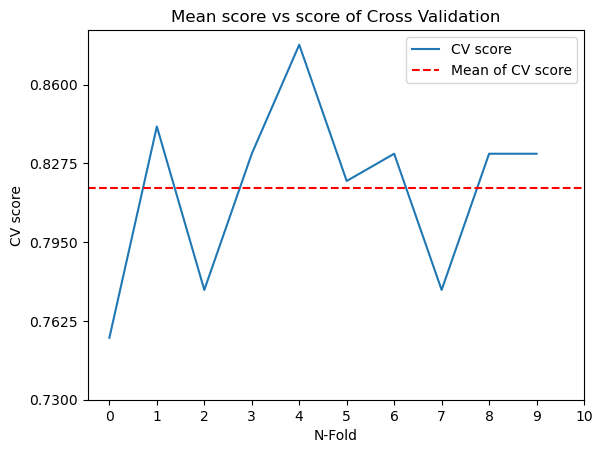

In [40]:
plt.plot(cv_score,label='CV score')
plt.xticks(range(0,11))
plt.yticks(np.linspace(0.73,0.86,5))
plt.axhline(np.mean(cv_score), color='r', linestyle='--', label='Mean of CV score')
plt.legend();
plt.title("Mean score vs score of Cross Validation");
plt.xlabel("N-Fold");
plt.ylabel("CV score");

The plot above shoved us, that the score of the model should be around 0.81, however we can see that the difference between minimum score and maximum score is about 0.12. So we can say, that different combination of our data, can really make a difference.

<Axes: >

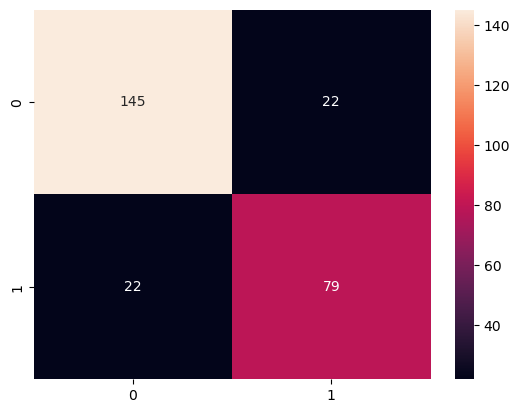

In [41]:
sns.heatmap(confusion_matrix(y_test,random_forest_predictions),fmt='g',annot=True)

In general we can say, that basic Random Forest model performed better than the logistic regression. We have less False Positives and False Negatives. Lets check the ROC Curve.

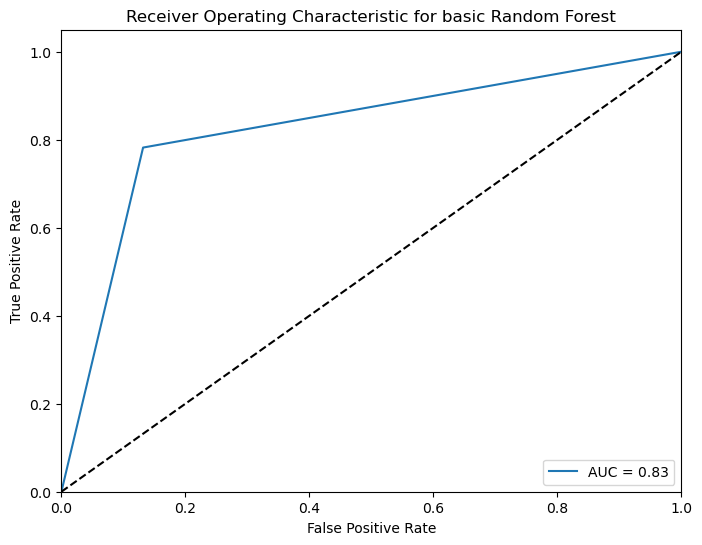

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, random_forest_predictions)
roc_auc = roc_auc_score(y_test, random_forest_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for basic Random Forest')
plt.legend(loc='lower right')
plt.show()

The AUC score is also better in comparisiom to the logisic regression. However we can check, if we can do better. The biggest problem in models of tree type, is the depth of it, since that's the main reason why decision trees lead to overfitting cause, every tree want to classify every record. Lets perform a gridsearch to try to fix that.


In [43]:
random_forest_grid = RandomForestClassifier()
X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
params_random_forest = {'n_estimators':[50,100,150,200],'max_depth':[2,3,4]}
grid_search_random = GridSearchCV(random_forest_grid,params_random_forest,scoring='accuracy')
grid_search_random.fit(X_train,y_train)
print(f"The best parameters for Random Forest are: {grid_search_random.best_params_}")
print(f"The best score for best parameters is equal to {grid_search_random.best_score_}")


The best parameters for Random Forest are: {'max_depth': 4, 'n_estimators': 150}
The best score for best parameters is equal to 0.8154064516129033


In [44]:
random_forest_best = RandomForestClassifier(n_estimators=150, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
random_forest_best.fit(X_train,y_train)
random_forest_best_predictions = random_forest_best.predict(X_test)
print(f"Score on training set is equal to {round(random_forest_best.score(X_train,y_train),3)}")
print(f"Score on testing data is equal to {round(random_forest_best.score(X_test,y_test),3)}")
print(classification_report(y_test,random_forest_best_predictions))

Score on training set is equal to 0.841
Score on testing data is equal to 0.828
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       167
           1       0.82      0.70      0.76       101

    accuracy                           0.83       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268



<Axes: >

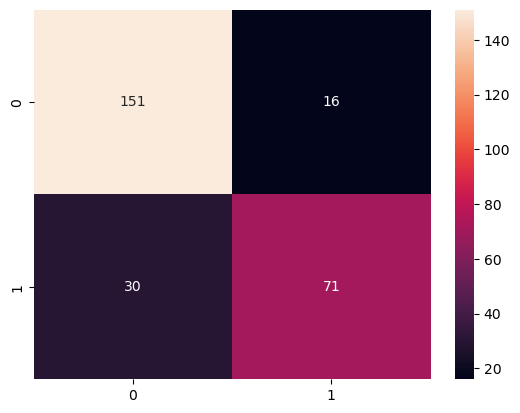

In [45]:
sns.heatmap(confusion_matrix(y_test,random_forest_best_predictions),fmt='g',annot=True)

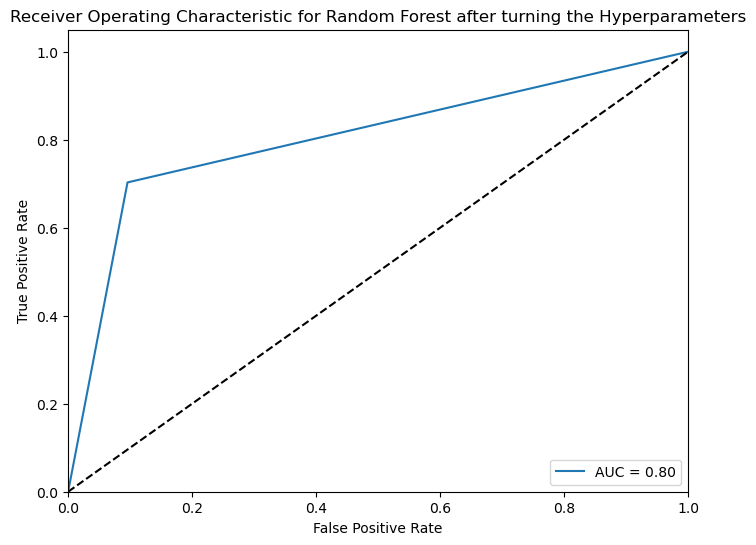

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, random_forest_best_predictions)
roc_auc = roc_auc_score(y_test, random_forest_best_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest after turning the Hyperparameters')
plt.legend(loc='lower right')
plt.show()

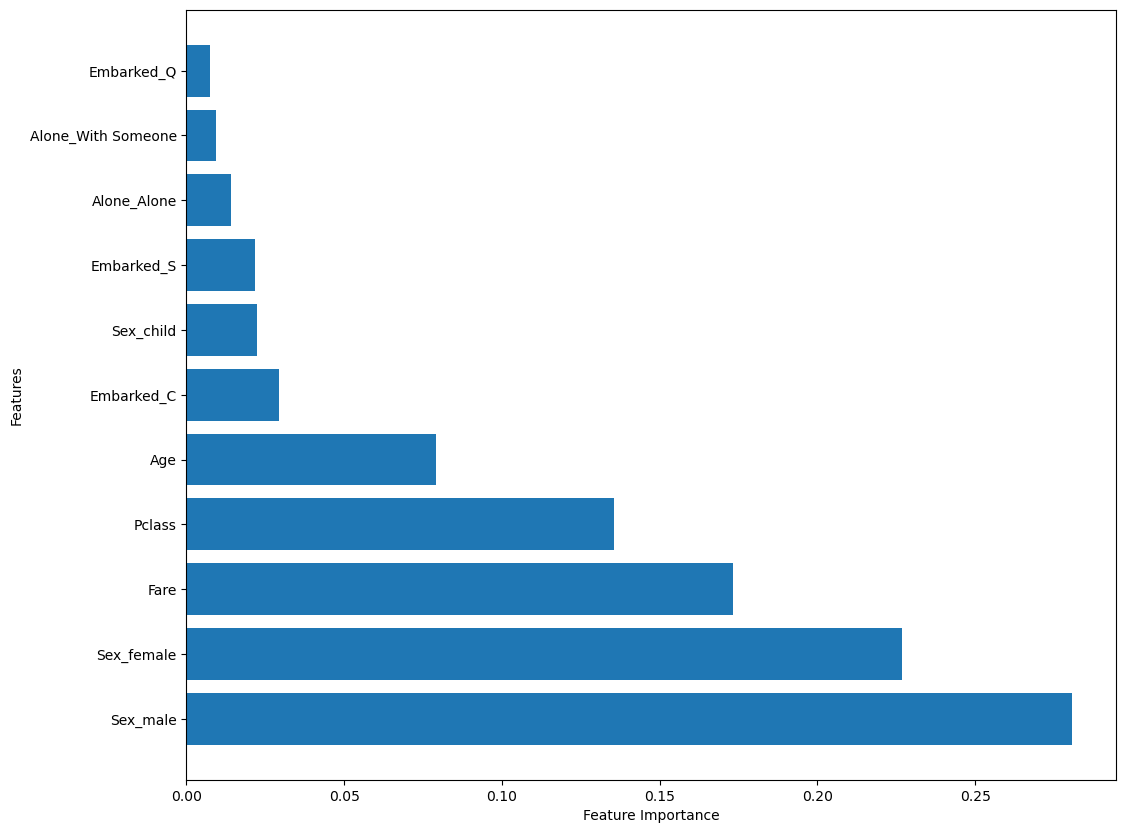

In [47]:
plt.figure(figsize=(12, 10))
sorted_indices = np.argsort(random_forest_best.feature_importances_)
sorted_values = random_forest_best.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

Turning the Hyperparameters, removed the big difference between scores on test and training set, however at some cost. We have lost some False Positives but we gain some False Negatives. The value under the AUC curve also have dropped a little, however it's still better than the logistic regression. After showing the feature importances of tuned Random Forest Model, we can see that variable Sex_male is now in the  1'st place as it should be based on our EDA. However the values Fare and Age are still kinda high in the hierarchy.

4. Gradient Boosting - Recently, gradient-based reinforcement learning models have gained popularity. It's beacause most of the times, those kind of models were having the best metrics in terms of evaluating the model. It uses weak and strong learners. So basicly, the model is giving higher weights to the entries, where prediction is not right. The next weak learner models is being learned on those new weights, and so on. The prediction of all weak models are combined to create a final prediction, this proces is performed multiple times until the stop criterion is met. The final prediction is based on the majority vote.

In [48]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)

gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train,y_train)
gradient_predictions = gradient_model.predict(X_test)
print(f"The accuracy score on training dataset is equal to: {round(gradient_model.score(X_train,y_train),3)}")
print(f"The accuracy on the test dataset is equal to: {round(gradient_model.score(X_test,y_test),3)} ")
print(classification_report(y_test,gradient_predictions))



The accuracy score on training dataset is equal to: 0.905
The accuracy on the test dataset is equal to: 0.821 
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       167
           1       0.78      0.73      0.76       101

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



<Axes: >

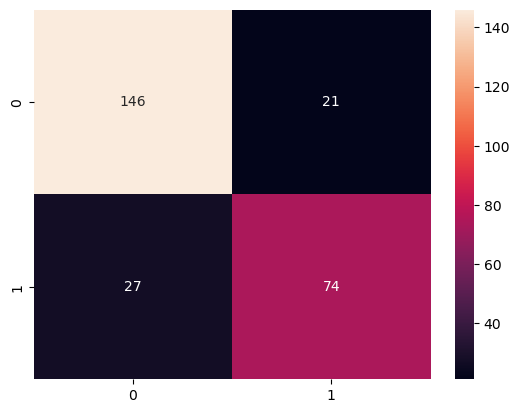

In [49]:
sns.heatmap(confusion_matrix(y_test,gradient_predictions),annot=True,fmt='g')

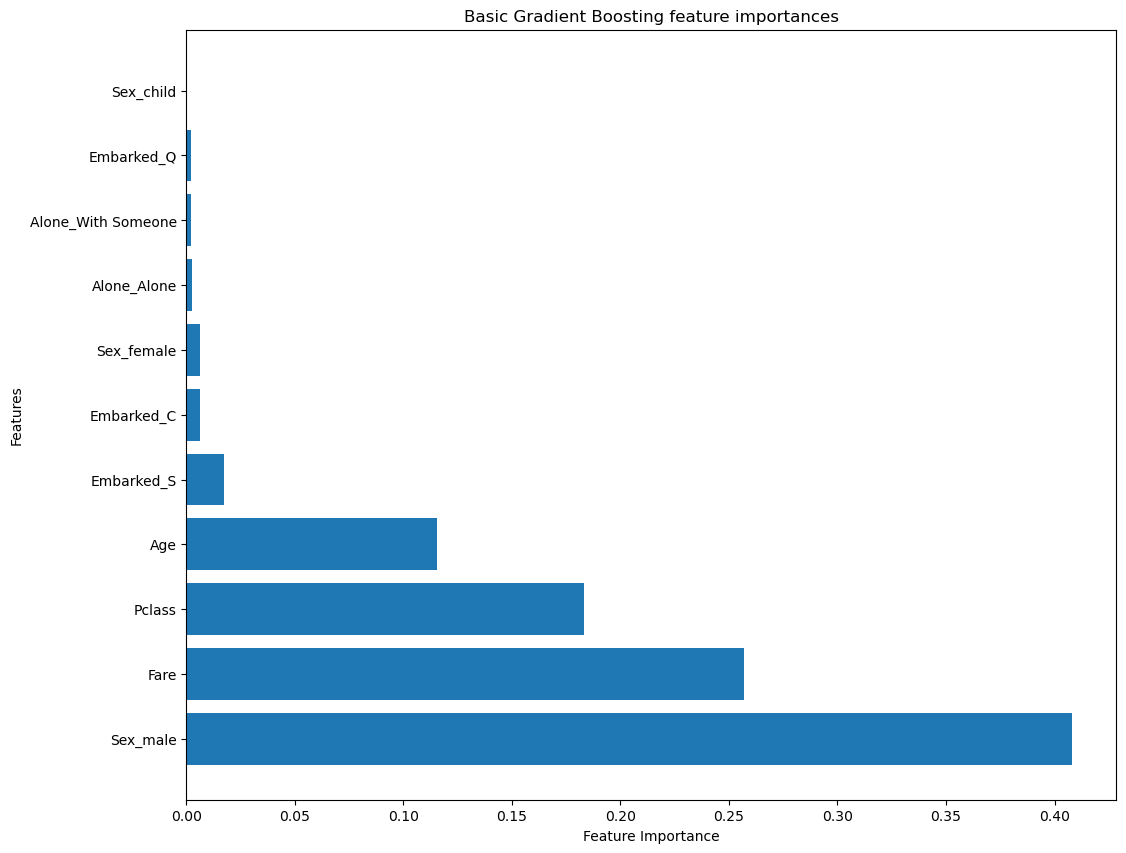

In [50]:
plt.figure(figsize=(12, 10))
sorted_indices = np.argsort(gradient_model.feature_importances_)
sorted_values = gradient_model.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title('Basic Gradient Boosting feature importances')
plt.show()

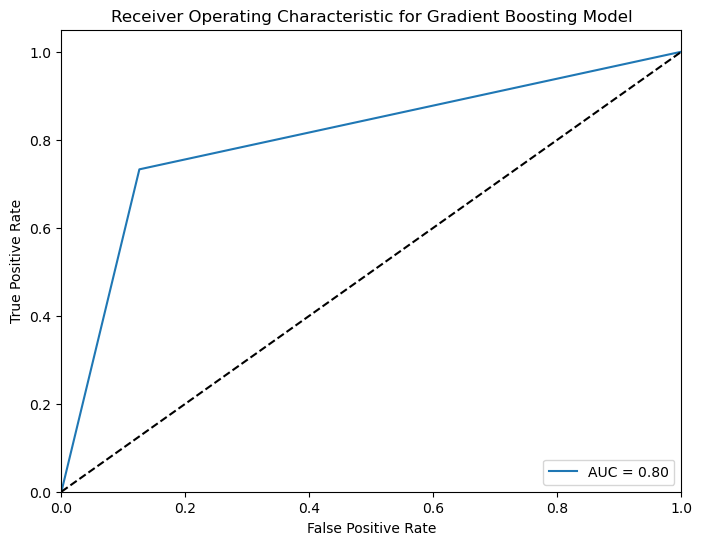

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, gradient_predictions)
roc_auc = roc_auc_score(y_test, gradient_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient Boosting Model')
plt.legend(loc='lower right')
plt.show()

The overall results of the model is similar to the random forest model. Our ROC value is the same as in the Random Forest model, however we have more False Positives and more False Negatives. We can also perform a grid search to try to find the best parameters.

In [52]:
params = {'loss':['log_loss','exponential'],
          'learning_rate':[0.01,0.05,0.1],
          'n_estimators':[100,150,200,250,300,350],
          'max_depth':[3,4,5],
          'max_leaf_nodes':[10,15,20]}

gradient_model = GradientBoostingClassifier()
X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
grid_search_boost = GridSearchCV(gradient_model,params,cv=5,scoring='accuracy')
grid_search_boost.fit(X_train,y_train)
print(f"The best parameters of the Gradient Boosting Model are:{grid_search_boost.best_params_}")
print(f"The best accuracy we can get is {grid_search_boost.best_score_}")


The best parameters of the Gradient Boosting Model are:{'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200}
The best accuracy we can get is 0.8314709677419355


Lets build that model.

In [53]:
X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=102)
gradient_best_model = GradientBoostingClassifier(loss='exponential',
                                                 learning_rate=0.01,
                                                 n_estimators=200,
                                                 max_depth=3,
                                                 max_leaf_nodes=10)
gradient_best_model.fit(X_train,y_train)
gradient_best_predictions = gradient_best_model.predict(X_test)
print(f"The accuracy score on training dataset is equal to: {round(gradient_best_model.score(X_train,y_train),3)}")
print(f"The accuracy on the test dataset is equal to: {round(gradient_best_model.score(X_test,y_test),3)} ")
print(classification_report(y_test,gradient_best_predictions))

The accuracy score on training dataset is equal to: 0.841
The accuracy on the test dataset is equal to: 0.817 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       167
           1       0.79      0.70      0.74       101

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



<Axes: >

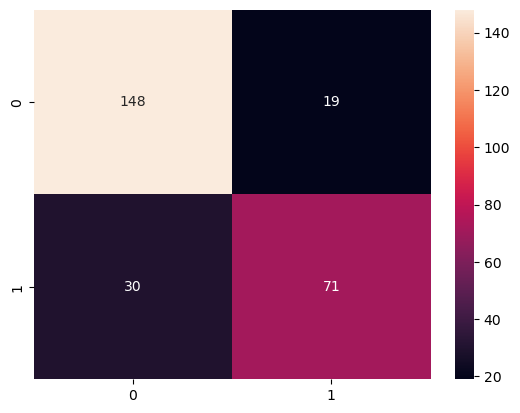

In [54]:
sns.heatmap(confusion_matrix(y_test,gradient_best_predictions),annot=True,fmt='g')

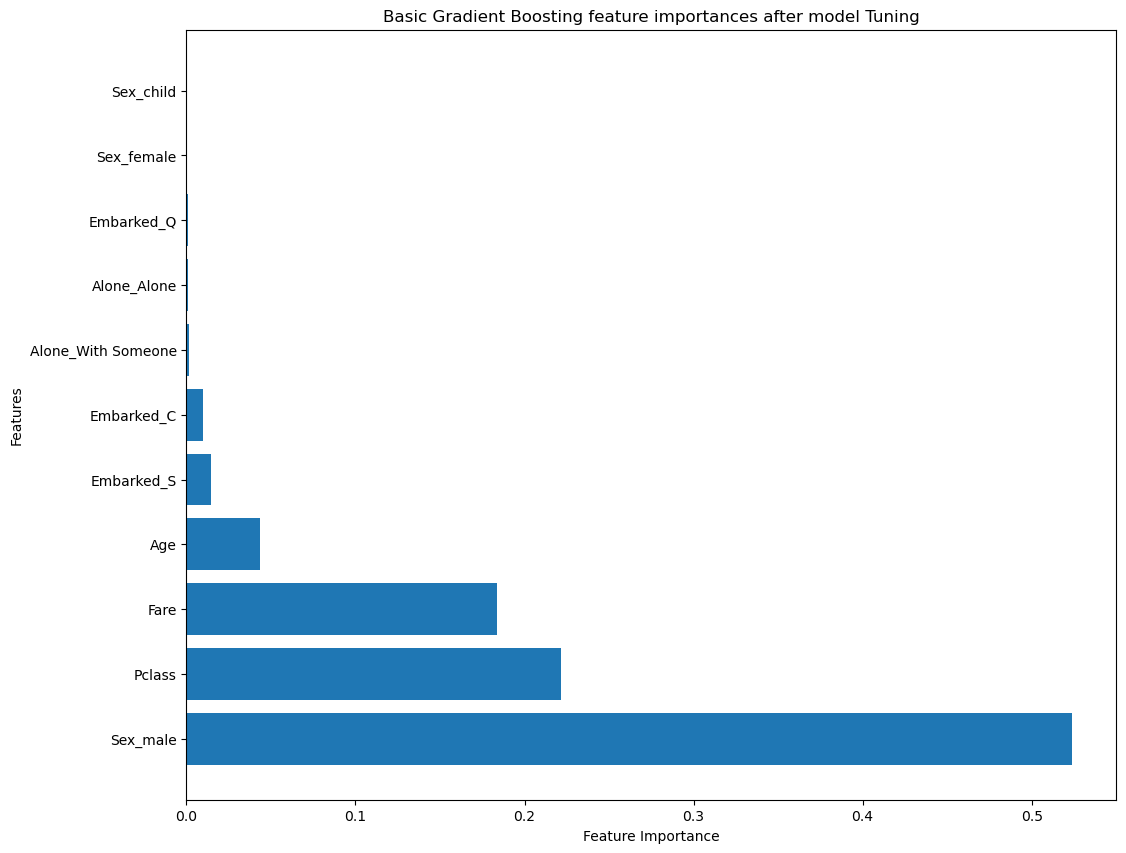

In [55]:
plt.figure(figsize=(12, 10))
sorted_indices = np.argsort(gradient_best_model.feature_importances_)
sorted_values = gradient_best_model.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title('Basic Gradient Boosting feature importances after model Tuning')
plt.show()

We can see, that after all, Gradient Boosting model, performed a little bit worse that Random Forest. In nowadays gradient boosting models, are one of the most popular models, however not all of the times they are performing better than other models.

In conclusion, based on accuracy, models like Random Forest, Gradient Boosting berformed the best, since they have got 82%. However there would be some room for improvement, like: handling the situation with the outliers, changing the features in several models or many many others. 